In [1]:
# import libraries
import itertools
import asyncio
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
from rtlsdr import RtlSdr
import pyModeS as pms
import gc
import pdb
import time

%matplotlib inline

In [2]:
sdr = RtlSdr()
fs = 2048000;
sdr.set_sample_rate(fs)    # sampling rate
sdr.set_center_freq(434.03e6)   # 1090MhZ center frequency
sdr.set_gain(0) 
N_Samples = 2048000 # approx 1 sec

Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [3]:
THRESHOLD = 0.015
PREAMBLE_SEQUENCE = [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]

In [4]:
def convert_to_binary(sequence):
    return [int(val > THRESHOLD) for val in sequence]

In [5]:
def downsample(sample, orig_freq, new_freq):
    assert 0 < new_freq < orig_freq, "New freq must be less than original frequency and greater than zero"
    assert orig_freq / new_freq == orig_freq // new_freq, "Original frequency must be a multiple of the new frequency"
    return sample[::orig_freq // new_freq]

In [6]:
def detect_data_from_preamble(buffer, i):
    detected_indices = []
    new_i = i
    for j in range(i, len(buffer) - 32):
        # Compute the score
        score = (buffer[j:j+16] == PREAMBLE_SEQUENCE)
        # If score == 1, return i + 16
        if score == True:
            detected_indices.append(j)
            new_i = j+32
        
    return detected_indices, new_i

In [7]:
def decode(pulse_pattern):
    result = []
    assert len(pulse_pattern) == 16
    for i in range(0, 16, 2):
        if pulse_pattern[i] == 1 and pulse_pattern[i+1] == 0:
            result.append(1)
        elif pulse_pattern[i+1] == 1 and pulse_pattern[i] == 0:
            result.append(0)
        else:
            result.append(0)
    res = 0
    for i in range(8):
        res += 2**(i) * result[i]
    return res

def convert_to_char(ascii_index):
    return chr(ascii_index)
    

In [8]:
def read_and_return_data(buffer):
    y = abs(sdr.read_samples(N_Samples))   # get samples
    y = downsample(y, fs, 200)
    data = convert_to_binary(y)
    buffer.extend(data)
    return buffer

In [19]:
def plot_data(data):
    width, height = figaspect(0.2)
    fig = figure(figsize=(width * 3,height * 3))
    p = plot( (data))
    title('magnitude of received signal')
    xlabel('samples')

In [10]:
def extract_chars_from_data(buffer, i):
    res = []
    detected, new_i = detect_data_from_preamble(buffer, i)
    for item in detected:
        char = convert_to_char(decode(buffer[item+16:item+32]))
        res.append(char)
    return res, new_i

In [11]:
def correlation(template, buffer):
    t_len = len(template)
    b_len = len(buffer)
    correlations = []
    for i in range(b_len - t_len + 1):
        correlation = 0
        for j in range(t_len):
            if template[j] == buffer[i+j]:
                correlation += 1
        correlations.append(correlation / t_len)
    return correlations

In [ ]:
# Steps
# 1) Apply a smoothing filter on the data to remove noise and jitter
# 2) Use k-means clustering to find high and low values in the data
# 3) do clock recovery
#   a) Take the fourier transform
#   b) Look in the 90 to 110 Hz range to find the pulse frequency
# 4) Use that to sample our signal at the the right sampling rate and recover the data

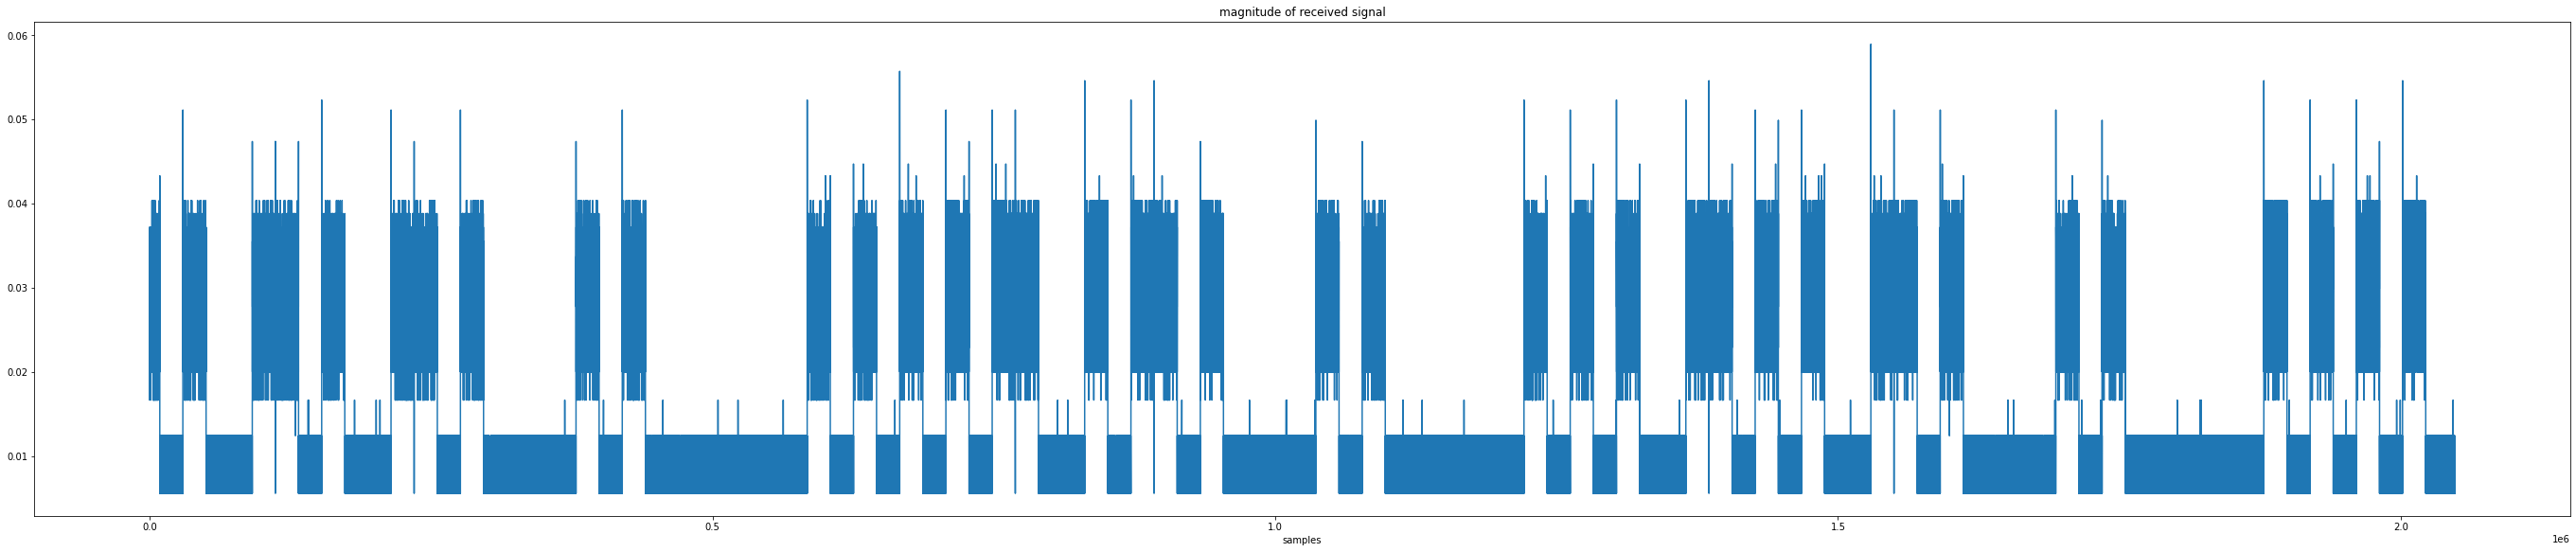

In [33]:
data = abs(sdr.read_samples(N_Samples))
plot_data(data)

In [24]:
data_fft = fft(data)
N = len(data)
n = np.arange(N)
T = N/fs
freq = n/T 

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.stem(freq, np.abs(data_fft), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

plt.subplot(122)
plt.plot(t, ifft(data_fft), 'r')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

NameError: name 't' is not defined

Error in callback <function flush_figures at 0x7fd468aa6f70> (for post_execute):


KeyboardInterrupt: 

(array([1.253879e+06, 0.000000e+00, 0.000000e+00, 8.767700e+04,
        0.000000e+00, 0.000000e+00, 1.436530e+05, 0.000000e+00,
        3.278180e+05, 2.010680e+05, 0.000000e+00, 0.000000e+00,
        3.002700e+04, 3.624000e+03, 0.000000e+00, 0.000000e+00,
        1.580000e+02, 4.900000e+01, 3.900000e+01, 8.000000e+00]),
 array([0.00554594, 0.00728739, 0.00902884, 0.0107703 , 0.01251175,
        0.01425321, 0.01599466, 0.01773612, 0.01947757, 0.02121902,
        0.02296048, 0.02470193, 0.02644339, 0.02818484, 0.02992629,
        0.03166775, 0.0334092 , 0.03515066, 0.03689211, 0.03863357,
        0.04037502]),
 <BarContainer object of 20 artists>)

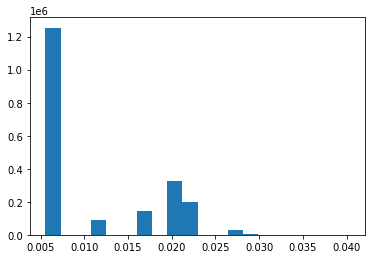

In [13]:
hist(data, bins=20)

In [14]:
buffer = []
i = 0
start = time.time()
while True:
    # pdb.set_trace()
#     buffer = read_and_return_data(buffer)
    #     current = time.time()
    y = abs(sdr.read_samples(N_Samples))   # get samples
    y = downsample(y, fs, 100)
    current = time.time()
    print(f"{current - start} elapsed time")
    print(f"Read {len(y)}")
    start = current
    # buffer.append(y)
    
#     chars, new_i = extract_chars_from_data(buffer, i)
#     print("".join(chars), end="")
#     i = new_i

1.0564355850219727 elapsed time
Read 100
1.0476250648498535 elapsed time
Read 100
1.0378034114837646 elapsed time
Read 100
1.0628960132598877 elapsed time
Read 100
1.0572552680969238 elapsed time
Read 100
1.0559759140014648 elapsed time
Read 100
1.0519816875457764 elapsed time
Read 100


KeyboardInterrupt: 

In [15]:
hist(list(buffer[0]) + list(buffer[1]), bins=30)

IndexError: list index out of range

In [34]:
async def streaming(buffer_1s, downsampled_buffer, start_time):
#     pdb.set_trace()
    i = 0
    async for samples in sdr.stream():
        buffer_1s.extend(abs(samples))
        if len(buffer_1s) > fs:
            raw_downsamples = downsample(buffer_1s[:fs], fs, 100)
            downsamples = convert_to_binary(raw_downsamples)
            downsampled_buffer.extend(downsamples)
            # print(raw_downsamples)
            
            # break
            buffer_1s = buffer_1s[fs:]
            chars, new_i = extract_chars_from_data(downsampled_buffer, i)
            print("".join(chars), end="")
            i = new_i
        current = time.time()
            
#         print(buffer_1s[:100])
#         print(raw_downsamples)
#         print(downsamples)
#         print(f"{current - start_time} elapsed time")
#         print(f"Read {len(samples)}, total downsampled buffer length {len(downsampled_buffer)}")
#         print(f"Average downsampled samples / sec {len(downsampled_buffer) / (current - start_time)}")

In [ ]:
buffer_1s = []
downsampled_buffer = []
start_time = time.time()
await streaming(buffer_1s, downsampled_buffer, start_time)

hello wo
ld!NF!E+lkld!hllo world¡hello worl!hello w h wolD! Hd pldhllo wor dhedrlello world!hell world!helo world!ello worl!hello wo2ld!hello wrld!helloworld!hel o world!hllo world!hello worl!hello wo
ld!hello orld!hello world!helo world!hllo orldhello wor,d!hello wold!hello  orld!hell world!helo world!hello worldhello wor d!hello wrld!hello world!hell world!helo world!ello worl$!hello word!hello w rld!helloworld!helo world!hello world!ello worl!hello wold!hello world!helloworld!helo world!hllo world¡hello world!hello wold!hello  orld!hell world!helo world!hello worldhello wor d!hello wrld!hello world!hell world!helo worldello worldhello w

In [46]:
raw_downsamples = [0.02772967769359, 0.005545935538718, 0.005545935538718, 0.03373460889036321, 0.02772967769359, 0.005545935538718, 0.005545935538718, 0.033734608890363185, 0.02986577688574071, 0.005545935538718, 0.005545935538718, 0.029865776885740814, 0.02986577688574071, 0.005545935538718, 0.005545935538718, 0.03373460889036321, 0.02772967769359011, 0.005545935538718, 0.005545935538718, 0.029865776885740814, 0.02772967769359, 0.005545935538718, 0.005545935538718, 0.03551131426720554, 0.02772967769359011, 0.005545935538718, 0.005545935538718, 0.03373460889036312, 0.02986577688574071, 0.005545935538718, 0.005545935538718, 0.029865776885740814, 0.02772967769359011, 0.005545935538718, 0.005545935538718, 0.03373460889036321, 0.02772967769359011, 0.005545935538718, 0.005545935538718, 0.02986577688574071, 0.03551131426720554, 0.005545935538718, 0.005545935538718, 0.029865776885740814, 0.02986577688574071, 0.005545935538718, 0.005545935538718, 0.02772967769359011, 0.03373460889036321, 0.005545935538718, 0.005545935538718, 0.0372032665902162, 0.033734608890363275, 0.005545935538718, 0.005545935538718, 0.029865776885740814, 0.03551131426720554, 0.005545935538718, 0.005545935538718, 0.033734608890363275, 0.03373460889036312, 0.005545935538718, 0.005545935538718, 0.029865776885740814, 0.033734608890363185, 0.005545935538718, 0.005545935538718, 0.03373460889036312, 0.02986577688574071, 0.005545935538718, 0.005545935538718, 0.03373460889036321, 0.03551131426720554, 0.005545935538718, 0.005545935538718, 0.02986577688574071, 0.0372032665902162, 0.005545935538718, 0.005545935538718, 0.02986577688574071, 0.029865776885740814, 0.005545935538718, 0.005545935538718, 0.033734608890363275, 0.029865776885740814, 0.005545935538718, 0.005545935538718, 0.02986577688574071, 0.03882154877102616, 0.005545935538718, 0.005545935538718, 0.03551131426720543, 0.02772967769359, 0.005545935538718, 0.005545935538718, 0.005545935538718, 0.029865776885740814, 0.033734608890363275, 0.005545935538718, 0.005545935538718, 0.03551131426720543, 0.03373460889036312, 0.005545935538718, 0.005545935538718, 0.02772967769359, 0.03882154877102608, 0.005545935538718, 0.005545935538718, 0.03551131426720543, 0.033734608890363185, 0.005545935538718, 0.005545935538718, 0.03551131426720554, 0.0372032665902162, 0.005545935538718, 0.005545935538718, 0.03551131426720554, 0.03551131426720554, 0.005545935538718, 0.005545935538718, 0.02772967769359008, 0.033734608890363185, 0.005545935538718, 0.005545935538718, 0.03551131426720543, 0.03551131426720543, 0.005545935538718, 0.005545935538718, 0.02986577688574071, 0.040375020160733244, 0.005545935538718, 0.005545935538718, 0.03551131426720543, 0.03373460889036312, 0.005545935538718, 0.005545935538718, 0.0372032665902161, 0.038821548771026004, 0.005545935538718, 0.005545935538718, 0.0372032665902162, 0.0372032665902162, 0.005545935538718, 0.005545935538718, 0.02986577688574071, 0.03551131426720543, 0.005545935538718, 0.005545935538718, 0.02772967769359, 0.02986577688574071, 0.005545935538718, 0.005545935538718, 0.03551131426720554, 0.0372032665902162, 0.005545935538718, 0.005545935538718, 0.03551131426720543, 0.03551131426720554, 0.005545935538718, 0.005545935538718, 0.02772967769359, 0.02986577688574071, 0.005545935538718, 0.005545935538718, 0.0372032665902162, 0.03373460889036312, 0.005545935538718, 0.005545935538718, 0.03551131426720554, 0.02772967769359008, 0.005545935538718, 0.005545935538718, 0.033734608890363275, 0.03373460889036312, 0.005545935538718, 0.005545935538718, 0.0372032665902161, 0.03551131426720554, 0.005545935538718, 0.005545935538718, 0.03551131426720554, 0.0372032665902161, 0.005545935538718, 0.005545935538718, 0.0372032665902162, 0.02772967769359, 0.005545935538718, 0.005545935538718, 0.02986577688574071, 0.03551131426720554, 0.005545935538718, 0.005545935538718, 0.0372032665902162, 0.0372032665902161, 0.005545935538718, 0.005545935538718, 0.02772967769359, 0.02772967769359, 0.005545935538718, 0.005545935538718]

In [25]:
data = [0.022866478019001095, 0.005545935538718, 0.02772967769359011, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359008, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.03373460889036312, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.03551131426720543, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359016, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.033734608890363275, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.02772967769359016, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.0372032665902162, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.029865776885740814, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.03551131426720543, 0.005545935538718, 0.03373460889036312, 0.005545935538718, 0.033734608890363185, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.02772967769359011, 0.005545935538718, 0.033734608890363275, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.033734608890363275, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.033734608890363185, 0.005545935538718, 0.03551131426720543, 0.005545935538718, 0.022866478019001095, 0.005545935538718, 0.02772967769359011, 0.005545935538718, 0.02772967769359, 0.005545935538718, 0.03373460889036321, 0.005545935538718, 0.03551131426720554, 0.005545935538718, 0.02986577688574071, 0.005545935538718, 0.02772967769359008, 0.005545935538718, 0.02772967769359, 0.005545935538718]

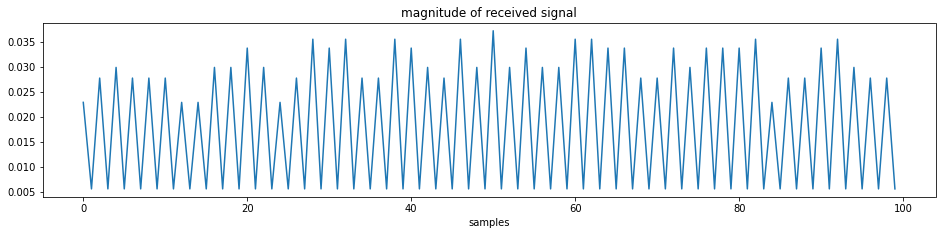

In [26]:
plot_data(data)

In [17]:
buffer

[array([0.00554594, 0.01240109, 0.00554594, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.02286648, 0.02286648,
        0.02772968]),
 array([0.02772968, 0.02772968, 0.02986578, ..., 0.00554594, 0.00554594,
        0.01240109]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.02286648, 0.02986578,
        0.01999615]),
 array([0.01999615, 0.02286648, 0.02286648, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.02986578, 0.02986578,
        0.02772968]),
 array([0.02772968, 0.01999615, 0.02986578, ..., 0.02986578, 0.02986578,
        0.02772968]),
 array([0.03551131, 0.02986578, 0.03373461, ..., 0.00554594, 0.00554594,
        0.00554594]),
 array([0.00554594, 0.00554594, 0.00554594, ..., 0.03373461, 0.03373461,
        0.02986578]),
 array([0.02986578, 0.02772968, 0.03551131, ..., 0

In [1]:
buffer = [0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]

In [2]:
template = [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]

Text(0, 0.5, 'Value')

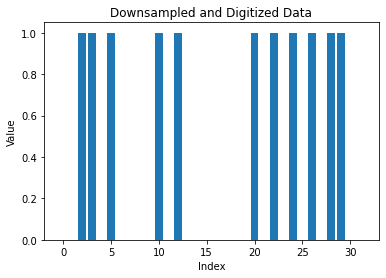

In [18]:
bar(range(32), buffer[:32])
title("Downsampled and Digitized Data")
xlabel("Time (us)")
ylabel("Value")

Text(0, 0.5, 'Value')

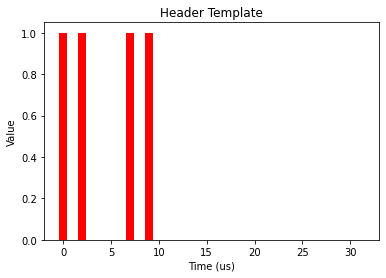

In [40]:
bar(range(32), template + 16 * [0], color="red")
title("Header Template")
xlabel("Time (us)")
ylabel("Value")

([<matplotlib.axis.XTick at 0x7f967c3eaaf0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

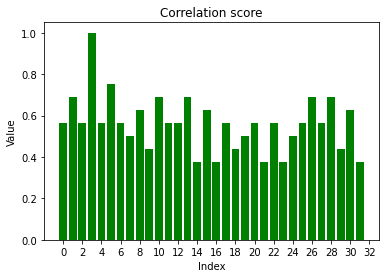

In [39]:
bar(range(32), correlation(template, buffer[:32 + 15]), color="green", )
title("Correlation score")
xlabel("Time (us)")
ylabel("Value")
xticks(np.arange(0, 33, 2))

In [27]:
len(correlation(template, buffer[:32]))

17

In [2]:
transmission_only = [(0,200), (500, 198), (1000, 191), (1500, 161), (2000, 83), (2500, 19), (3000, 16), (3500, 3), (4000, 0)]
transmission_and_error_correction = [(0, 100), (500, 99), (1000, 99), (1500, 98), (2000, 96), (2500, 91), (3000, 80), (3500, 56), (4000, 25)]
transmission_and_error_correction_and_compression = [(0, 193), (500, 187), (1000, 186), (1500, 183), (2000, 170), (2500, 131), (3000, 102), (3500, 64), (4000, 27)]

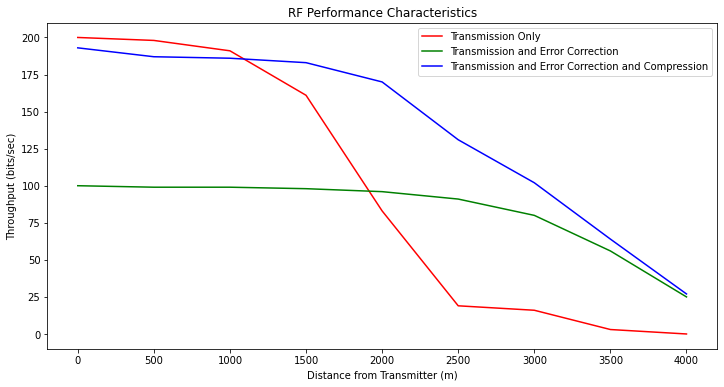

In [11]:
figure(figsize=(12, 6))
plot([x[0] for x in transmission_only], [x[1] for x in transmission_only], 'r-', label='Transmission Only')
plot([x[0] for x in transmission_and_error_correction], [x[1] for x in transmission_and_error_correction], 'g-', label='Transmission and Error Correction')
plot([x[0] for x in transmission_and_error_correction_and_compression], [x[1] for x in transmission_and_error_correction_and_compression], 'b-', label='Transmission and Error Correction and Compression')
xlabel('Distance from Transmitter (m)')
ylabel('Throughput (bits/sec)')
title("RF Performance Characteristics")
legend(loc='upper right')
show()

In [7]:
[transmission_only[0] for x in transmission_only]

[(0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200),
 (0, 200)]